In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

# Load the CSV file into a DataFrame
data = pd.read_csv('housing_data_with_price_per_sqm.csv')

# Create a clean copy of the dataset to preserve the original data
data_clean = data.copy()

# List of regions to remove
regions_to_remove = ['Eastern Victoria', 'Northern Victoria', 'Western Victoria']

# Drop rows with missing values
data = data_clean.dropna().copy()  # Explicitly create a copy to avoid warnings

# Create a log-transformed column for 'Distance'
data['Log_Distance'] = np.log1p(data['Distance'])  # Use np.log1p for log(1 + x) transformation

# Create a squared column for 'Bathroom'
data['Sq_Bathroom'] = data['Bathroom'] ** 2

# Filter out specified regions
data = data[~data['Regionname'].isin(regions_to_remove)]

# Remove extreme values in 'Price_per_sqm' using the Interquartile Range (IQR)
Q1 = data['Price_per_sqm'].quantile(0.25)  # First quartile (25th percentile)
Q3 = data['Price_per_sqm'].quantile(0.75)  # Third quartile (75th percentile)
IQR = Q3 - Q1  # Interquartile range
lower_bound = Q1 - 1.5 * IQR  # Define lower bound
upper_bound = Q3 + 1.5 * IQR  # Define upper bound

# Apply filtering to remove outliers
data = data[(data['Price_per_sqm'] >= lower_bound) & (data['Price_per_sqm'] <= upper_bound)]

# Display a summary of the cleaned dataset
print(f"Dataset after preprocessing: {data.shape[0]} rows, {data.shape[1]} columns")
print(data.head())


Dataset after preprocessing: 11549 rows, 25 columns
      Suburb           Address  Rooms Type     Price Method   SellerG  \
0  Bellfield    20 Davidson St      3    h  773000.0      S    Nelson   
1  Bellfield    40 Plunkett St      3    h  885000.0      S    Nelson   
2  Bellfield        8 Erica Ct      3    h  770000.0      S  Haughton   
3  Bellfield  353 Waterdale Rd      2    h  855000.0      S     Barry   
4  Bellfield       305 Bell St      3    h  645000.0     SP    Nelson   

         Date  Distance  Postcode  ...  YearBuilt  CouncilArea  Lattitude  \
0   6/08/2016       9.5    3081.0  ...     1955.0   Abbotsford   -37.7520   
1  12/11/2016       9.5    3081.0  ...     1960.0   Abbotsford   -37.7509   
2  16/04/2016       9.5    3081.0  ...     1960.0   Abbotsford   -37.7529   
3  18/03/2017       9.5    3081.0  ...     1960.0   Abbotsford   -37.7534   
4  22/05/2016       9.5    3081.0  ...     1950.0   Abbotsford   -37.7506   

   Longtitude            Regionname  Propertyc

In [3]:
import pymc as pm
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity
from sklearn.utils import resample



# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


type_dummies = pd.get_dummies(data['Type'], prefix='Type')

# Compute mean landsize for each Type
data['type_mean_landsize'] = data.groupby('Type')['Landsize'].transform('mean')

# Cap outliers in 'Sq_Bathroom' using the IQR method
Q1 = data['Sq_Bathroom'].quantile(0.25)
Q3 = data['Sq_Bathroom'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data['Sq_Bathroom'] = data['Sq_Bathroom'].clip(lower=lower_bound, upper=upper_bound)

# Compute relative landsize
data['Relative_Landsize'] = data['Landsize'] - data['type_mean_landsize']

# Interaction terms: Relative_Landsize × Type
for col in type_dummies.columns:
    data[f'Relative_Landsize:{col}'] = data['Relative_Landsize'] * type_dummies[col]

# Estimate vicinity density using KDE
coords = data[['Lattitude', 'Longtitude']].dropna().values
kde = KernelDensity(bandwidth=0.01, kernel='gaussian')
kde.fit(coords)
data['vicinity_density'] = np.exp(kde.score_samples(data[['Lattitude', 'Longtitude']].fillna(0).values))

# Oversampling problematic data
problematic_type_h = data[(data['Relative_Landsize:Type_h'] < -150)]
problematic_type_t = data[(data['Relative_Landsize:Type_t'] < -50)]
oversampled_h = resample(problematic_type_h, replace=True, n_samples=500, random_state=42)
oversampled_t = resample(problematic_type_t, replace=True, n_samples=300, random_state=42)
data = pd.concat([data, oversampled_h, oversampled_t], ignore_index=True)


# Update Region_Type with merged small regions
data.loc[data['Regionname'] == 'South-Eastern Metropolitan', 'Regionname'] = 'Merged South-Eastern'
data['Region_Type'] = data['Regionname'] + '_' + data['Type']

# Overwrite Region_Type for Merged South-Eastern to exclude housing types
data.loc[data['Regionname'] == 'Merged South-Eastern', 'Region_Type'] = 'Merged South-Eastern'

# Map hierarchical indices for Region_Type (Type × Region effects)
region_type_codes = data['Region_Type'].map({name: i for i, name in enumerate(data['Region_Type'].unique())}).values

# Calculate prior means and standard deviations for Region_Type (Type × Region effects)
region_type_means = {rtype: data.loc[data['Region_Type'] == rtype, 'Price_per_sqm'].mean() for rtype in data['Region_Type'].unique()}
region_type_stds = {rtype: data.loc[data['Region_Type'] == rtype, 'Price_per_sqm'].std() for rtype in data['Region_Type'].unique()}

type_dummy_u = (data['Type'] == 'u').astype(int)

# Create the interaction term: Landsize × Type 'u'
data['Landsize:Type_u'] = data['Landsize'] * type_dummy_u

# Update predictors for design matrix
predictors = ['Log_Distance', 'Sq_Bathroom', 'Propertycount', 'vicinity_density'] + [
    f'Relative_Landsize:{col}' for col in type_dummies.columns]

X_raw = data[predictors]

# Standardize predictors
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

# Target variable
y = data['Price_per_sqm'].values

# Bayesian Model
with pm.Model() as model:
    # Global prior for intercept
    intercept = pm.Normal('intercept', mu=0, sigma=10)

    # Horseshoe prior for beta_main
    tau = pm.HalfCauchy('tau', beta=1)  # Global shrinkage parameter
    lambda_ = pm.HalfCauchy('lambda_', beta=1, shape=X.shape[1])  # Local shrinkage parameters
    beta_main = pm.Normal('beta_main', mu=0, sigma=tau * lambda_, shape=X.shape[1])

    # Hierarchical priors for Region_Type (Type × Region effects)
    region_type_effects = pm.Normal(
        'region_type_effects',
        mu=7300,
        sigma=1500,
        shape=len(data['Region_Type'].unique())
    )


    # Linear predictor
    mu = (
        intercept +
        pm.math.dot(X, beta_main) +
        region_type_effects[region_type_codes]
    )

    # Likelihood with Student-t distribution
    sigma = pm.HalfNormal('sigma', sigma=10)
    y_obs = pm.StudentT('y_obs', mu=mu, sigma=sigma, nu=3, observed=y)

    # Sampling with fixed random seed
    trace = pm.sample(
        2000, 
        return_inferencedata=True, 
        target_accept=0.95, 
        discard_tuned_samples=True, 
        random_seed=RANDOM_SEED
    )

# Summarize results
summary = pm.summary(
    trace, var_names=['intercept', 'beta_main', 'region_type_effects']
)
print(summary)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, tau, lambda_, beta_main, region_type_effects, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 71 seconds.


                             mean      sd    hdi_3%   hdi_97%  mcse_mean  \
intercept                  -1.575   9.932   -20.321    16.765      0.175   
beta_main[0]             -779.089  10.147  -797.775  -759.333      0.134   
beta_main[1]              137.391   5.747   126.442   147.718      0.064   
beta_main[2]               26.131   5.774    15.031    36.685      0.066   
beta_main[3]              -76.683   7.972   -91.261   -61.478      0.101   
beta_main[4]             -405.535   6.730  -418.024  -393.016      0.079   
beta_main[5]             -285.356   9.213  -303.492  -268.901      0.113   
beta_main[6]               68.504   8.690    52.389    84.825      0.091   
region_type_effects[0]   2311.174  21.194  2272.283  2351.505      0.286   
region_type_effects[1]   1809.227  14.666  1782.235  1837.443      0.226   
region_type_effects[2]   2678.159  15.988  2649.532  2709.487      0.233   
region_type_effects[3]   1748.752  15.165  1720.773  1776.460      0.227   
region_type_

In [4]:
region_type_names = data['Region_Type'].unique()

for idx, name in enumerate(region_type_names):
    print(f"interaction_region_type_effects[{idx}] corresponds to {name}")



interaction_region_type_effects[0] corresponds to Eastern Metropolitan_h
interaction_region_type_effects[1] corresponds to Northern Metropolitan_h
interaction_region_type_effects[2] corresponds to Southern Metropolitan_h
interaction_region_type_effects[3] corresponds to Western Metropolitan_h
interaction_region_type_effects[4] corresponds to Merged South-Eastern
interaction_region_type_effects[5] corresponds to Eastern Metropolitan_t
interaction_region_type_effects[6] corresponds to Northern Metropolitan_t
interaction_region_type_effects[7] corresponds to Southern Metropolitan_t
interaction_region_type_effects[8] corresponds to Western Metropolitan_t
interaction_region_type_effects[9] corresponds to Eastern Metropolitan_u
interaction_region_type_effects[10] corresponds to Northern Metropolitan_u
interaction_region_type_effects[11] corresponds to Southern Metropolitan_u
interaction_region_type_effects[12] corresponds to Western Metropolitan_u


In [5]:
predictors = ['Log_Distance', 'Sq_Bathroom', 'Propertycount', 'vicinity_density'] + [
    f'Relative_Landsize:{col}' for col in type_dummies.columns]

for idx, name in enumerate(predictors):
    print(f"beta_main[{idx}] corresponds to {name}")



beta_main[0] corresponds to Log_Distance
beta_main[1] corresponds to Sq_Bathroom
beta_main[2] corresponds to Propertycount
beta_main[3] corresponds to vicinity_density
beta_main[4] corresponds to Relative_Landsize:Type_h
beta_main[5] corresponds to Relative_Landsize:Type_t
beta_main[6] corresponds to Relative_Landsize:Type_u


In [6]:
print(data['Relative_Landsize'].isna().sum())  # Should be 0
print(data['Relative_Landsize'].describe())   # Look for extreme values

0
count    12349.000000
mean       -15.587873
std        207.779564
min       -517.792737
25%       -151.792737
50%         -7.476946
75%        129.207263
max        682.207263
Name: Relative_Landsize, dtype: float64


In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Create a DataFrame for predictors
X_predictors = pd.DataFrame(X, columns=predictors)

# Compute VIF for each predictor
vif_data = pd.DataFrame()
vif_data['Variable'] = X_predictors.columns
vif_data['VIF'] = [variance_inflation_factor(X_predictors.values, i) for i in range(X_predictors.shape[1])]

# Display VIF results
print(vif_data)

                   Variable       VIF
0              Log_Distance  1.967841
1               Sq_Bathroom  1.036368
2             Propertycount  1.011120
3          vicinity_density  1.772698
4  Relative_Landsize:Type_h  1.292126
5  Relative_Landsize:Type_t  1.018886
6  Relative_Landsize:Type_u  1.036379


**TESTING THE CODE**

Sampling: [y_obs]


Output()

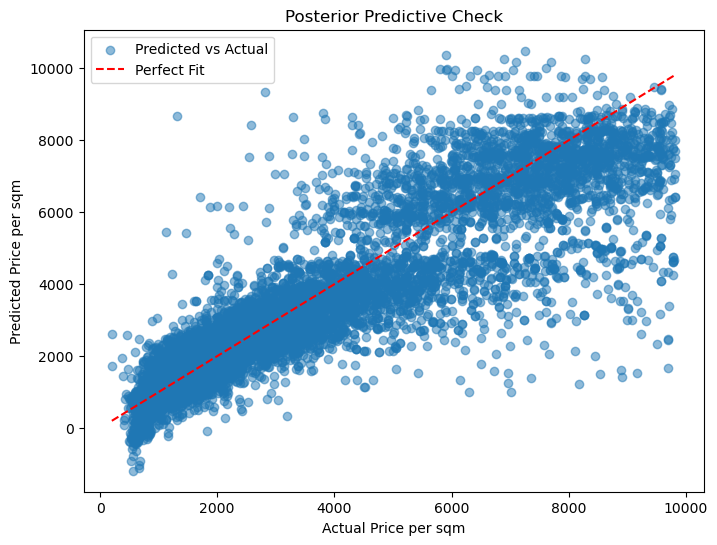

In [9]:
## Generate Posterior Predictive Samples
with model:
    ppc = pm.sample_posterior_predictive(trace, var_names=["y_obs"], random_seed=42)

## Compare Predicted vs Actual (Scatter Plot)
import matplotlib.pyplot as plt

# Compute the mean of posterior predictive samples
y_pred = ppc.posterior_predictive["y_obs"].mean(axis=(0, 1))  # Average across chains and draws

# Plot predicted vs actual
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred, alpha=0.5, label="Predicted vs Actual")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label="Perfect Fit")
plt.xlabel("Actual Price per sqm")
plt.ylabel("Predicted Price per sqm")
plt.title("Posterior Predictive Check")
plt.legend()
plt.show()


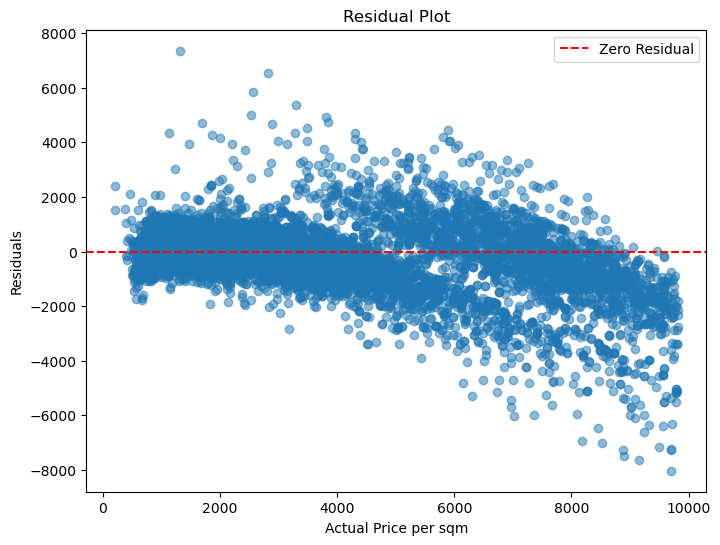

In [10]:
##Plot Residuals (Predicted - Actual):
residuals = y_pred - y
plt.figure(figsize=(8, 6))
plt.scatter(y, residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--', label="Zero Residual")
plt.xlabel("Actual Price per sqm")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.legend()
plt.show()


In [11]:
summary = pm.summary(trace, var_names=["intercept", "beta_main", "region_type_effects"])
print(summary)


                             mean      sd    hdi_3%   hdi_97%  mcse_mean  \
intercept                  -1.575   9.932   -20.321    16.765      0.175   
beta_main[0]             -779.089  10.147  -797.775  -759.333      0.134   
beta_main[1]              137.391   5.747   126.442   147.718      0.064   
beta_main[2]               26.131   5.774    15.031    36.685      0.066   
beta_main[3]              -76.683   7.972   -91.261   -61.478      0.101   
beta_main[4]             -405.535   6.730  -418.024  -393.016      0.079   
beta_main[5]             -285.356   9.213  -303.492  -268.901      0.113   
beta_main[6]               68.504   8.690    52.389    84.825      0.091   
region_type_effects[0]   2311.174  21.194  2272.283  2351.505      0.286   
region_type_effects[1]   1809.227  14.666  1782.235  1837.443      0.226   
region_type_effects[2]   2678.159  15.988  2649.532  2709.487      0.233   
region_type_effects[3]   1748.752  15.165  1720.773  1776.460      0.227   
region_type_

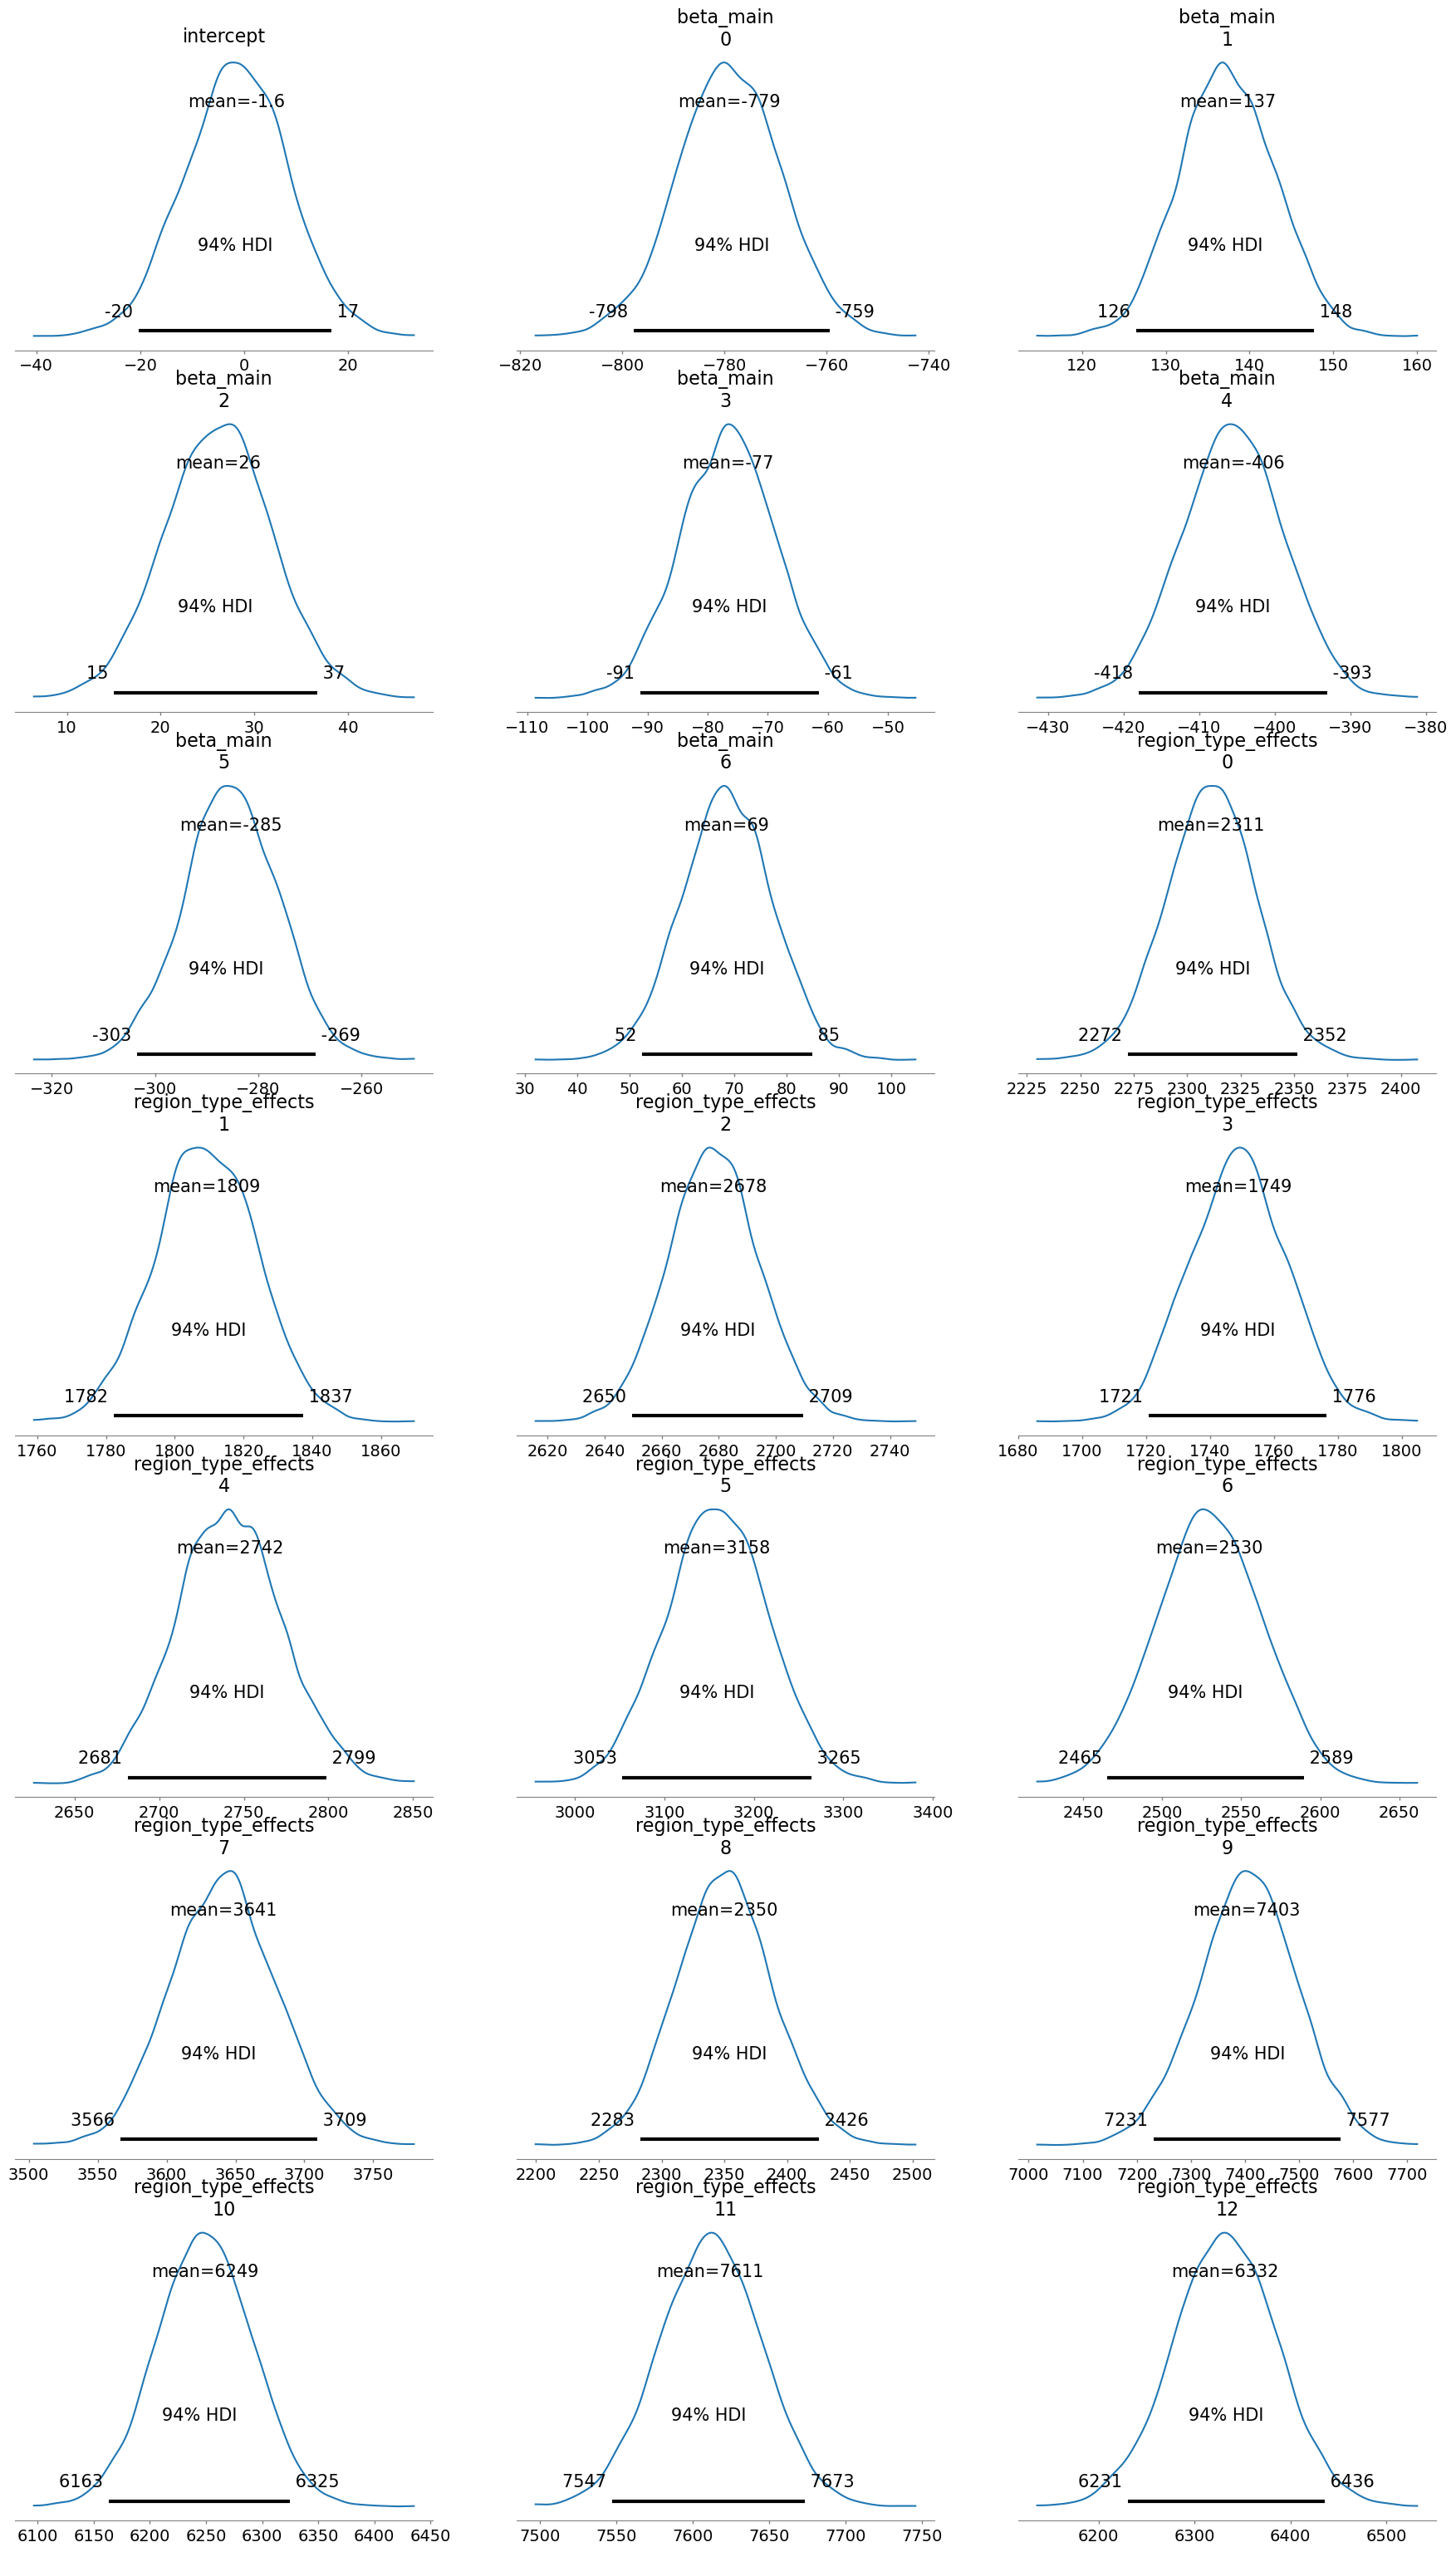

In [12]:
import arviz as az

az.plot_posterior(trace, var_names=["intercept", "beta_main", "region_type_effects"])
plt.show()


**Step** **3: Check Residual Distribution**
**Residuals should ideally follow a normal distribution centered around 0.**

**Plot Histogram of Residual**

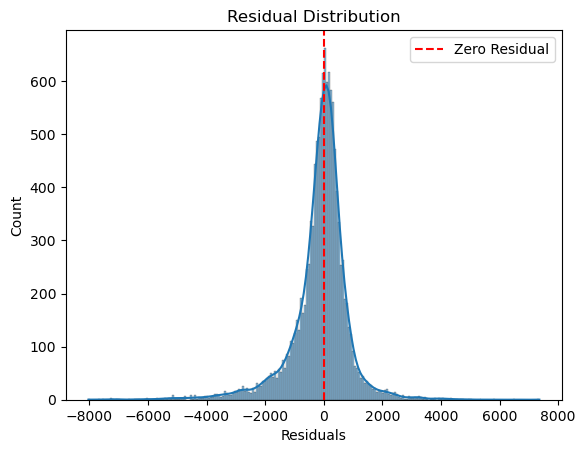

In [14]:
import seaborn as sns

sns.histplot(residuals, kde=True)
plt.axvline(0, color='r', linestyle='--', label="Zero Residual")
plt.xlabel("Residuals")
plt.title("Residual Distribution")
plt.legend()
plt.show()


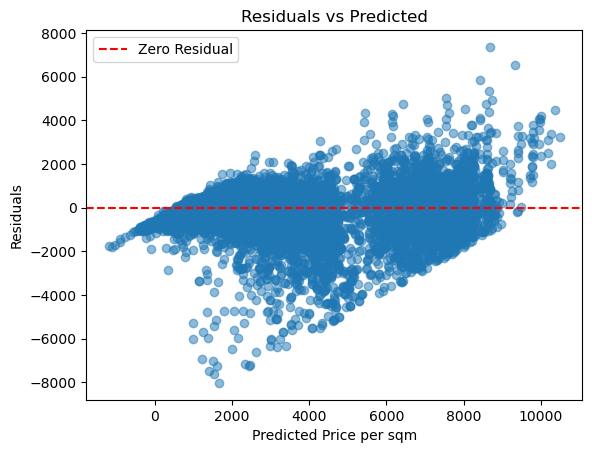

In [15]:
##Plot Residuals vs Predicted:

plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='r', linestyle='--', label="Zero Residual")
plt.xlabel("Predicted Price per sqm")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.legend()
plt.show()


In [16]:
##Valuate how well the model fits the data using goodness-of-fit measures.

##R² (Coefficient of Determination)

r2 = 1 - (np.sum((y - y_pred) ** 2) / np.sum((y - y.mean()) ** 2))
print(f"R²: {r2:.4f}")

##Mean Absolute Error (MAE):

mae = np.mean(np.abs(residuals))/data['Price_per_sqm'].mean()
print(f"Normalized Mean Absolute Error (MAE): {mae:.2f}")

##Root Mean Squared Error (RMSE):

mse = np.mean(residuals ** 2)/np.var(data['Price_per_sqm'])
print(f"Normalized Mean Squared Error (MSE): {mse:.2f}")

R²: 0.8103
Normalized Mean Absolute Error (MAE): 0.21
Normalized Mean Squared Error (MSE): 0.19
